<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[11:15:43] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


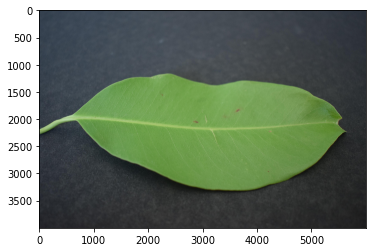

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

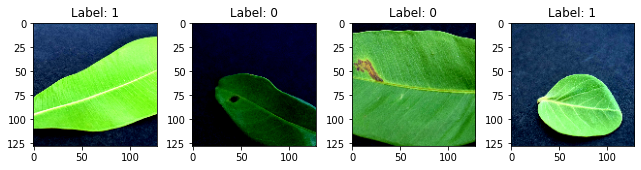

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
device = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, device=device)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), device=device))
model.hybridize()

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[11:15:49] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.to_device(device))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.to_device(device))
            loss = loss_fn(outputs, label.to_device(device))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

[11:15:50] /work/mxnet/src/operator/cudnn_ops.cc:353: Auto-tuning cuDNN op, set MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable


[11:15:51] /work/mxnet/src/operator/cudnn_ops.cc:353: Auto-tuning cuDNN op, set MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable


Epoch[1] Batch[5] Speed: 1.0975878956919591 samples/sec                   batch loss = 1.5307905673980713 | accuracy = 0.55


Epoch[1] Batch[10] Speed: 1.291933967985061 samples/sec                   batch loss = 0.968477725982666 | accuracy = 0.425


Epoch[1] Batch[15] Speed: 1.3009865875337048 samples/sec                   batch loss = 0.8516164422035217 | accuracy = 0.45


Epoch[1] Batch[20] Speed: 1.2895971046738588 samples/sec                   batch loss = 1.4384181499481201 | accuracy = 0.4875


Epoch[1] Batch[25] Speed: 1.3110324968865625 samples/sec                   batch loss = 1.457484245300293 | accuracy = 0.48


Epoch[1] Batch[30] Speed: 1.2891036453801976 samples/sec                   batch loss = 0.5608935952186584 | accuracy = 0.5083333333333333


Epoch[1] Batch[35] Speed: 1.2959692376381637 samples/sec                   batch loss = 0.4560462236404419 | accuracy = 0.5142857142857142


Epoch[1] Batch[40] Speed: 1.3083875946769268 samples/sec                   batch loss = 0.5696828961372375 | accuracy = 0.53125


Epoch[1] Batch[45] Speed: 1.3006174539266249 samples/sec                   batch loss = 0.4170425832271576 | accuracy = 0.5444444444444444


Epoch[1] Batch[50] Speed: 1.296629386636581 samples/sec                   batch loss = 0.5165963768959045 | accuracy = 0.565


Epoch[1] Batch[55] Speed: 1.2920001293754708 samples/sec                   batch loss = 0.6996763348579407 | accuracy = 0.5636363636363636


Epoch[1] Batch[60] Speed: 1.2907368722471604 samples/sec                   batch loss = 0.37674206495285034 | accuracy = 0.575


Epoch[1] Batch[65] Speed: 1.2931310935330174 samples/sec                   batch loss = 0.37912601232528687 | accuracy = 0.6


Epoch[1] Batch[70] Speed: 1.2911150235771482 samples/sec                   batch loss = 0.720848023891449 | accuracy = 0.6071428571428571


Epoch[1] Batch[75] Speed: 1.2984789950488629 samples/sec                   batch loss = 0.6132671236991882 | accuracy = 0.62


Epoch[1] Batch[80] Speed: 1.2978965790031087 samples/sec                   batch loss = 0.9923722147941589 | accuracy = 0.634375


Epoch[1] Batch[85] Speed: 1.294956734475616 samples/sec                   batch loss = 0.3367244303226471 | accuracy = 0.6441176470588236


Epoch[1] Batch[90] Speed: 1.2938234740683388 samples/sec                   batch loss = 0.5498645901679993 | accuracy = 0.6416666666666667


Epoch[1] Batch[95] Speed: 1.2954281787867081 samples/sec                   batch loss = 0.40019920468330383 | accuracy = 0.6473684210526316


Epoch[1] Batch[100] Speed: 1.2833153029994862 samples/sec                   batch loss = 0.7536378502845764 | accuracy = 0.64


Epoch[1] Batch[105] Speed: 1.2977586356266786 samples/sec                   batch loss = 0.332865834236145 | accuracy = 0.6452380952380953


Epoch[1] Batch[110] Speed: 1.295161268159391 samples/sec                   batch loss = 0.48418307304382324 | accuracy = 0.6522727272727272


Epoch[1] Batch[115] Speed: 1.299636033779102 samples/sec                   batch loss = 0.1645880937576294 | accuracy = 0.6565217391304348


Epoch[1] Batch[120] Speed: 1.299812642519867 samples/sec                   batch loss = 0.35327380895614624 | accuracy = 0.6604166666666667


Epoch[1] Batch[125] Speed: 1.2977390608858965 samples/sec                   batch loss = 0.6508800983428955 | accuracy = 0.666


Epoch[1] Batch[130] Speed: 1.3029682550321133 samples/sec                   batch loss = 0.4459560215473175 | accuracy = 0.6596153846153846


Epoch[1] Batch[135] Speed: 1.305061843204015 samples/sec                   batch loss = 0.2703840136528015 | accuracy = 0.6648148148148149


Epoch[1] Batch[140] Speed: 1.2984426164168026 samples/sec                   batch loss = 1.2765724658966064 | accuracy = 0.6642857142857143


Epoch[1] Batch[145] Speed: 1.2866177297582329 samples/sec                   batch loss = 0.42846667766571045 | accuracy = 0.6586206896551724


Epoch[1] Batch[150] Speed: 1.2945585490266553 samples/sec                   batch loss = 0.38025885820388794 | accuracy = 0.66


Epoch[1] Batch[155] Speed: 1.2989582376018523 samples/sec                   batch loss = 0.591364324092865 | accuracy = 0.6580645161290323


Epoch[1] Batch[160] Speed: 1.3000620305332804 samples/sec                   batch loss = 0.3006380498409271 | accuracy = 0.659375


Epoch[1] Batch[165] Speed: 1.2958627313070132 samples/sec                   batch loss = 0.7454145550727844 | accuracy = 0.6590909090909091


Epoch[1] Batch[170] Speed: 1.2916012739549805 samples/sec                   batch loss = 0.5054954290390015 | accuracy = 0.6558823529411765


Epoch[1] Batch[175] Speed: 1.2904851921865155 samples/sec                   batch loss = 0.18632923066616058 | accuracy = 0.6528571428571428


Epoch[1] Batch[180] Speed: 1.2952128616370409 samples/sec                   batch loss = 0.538542628288269 | accuracy = 0.6541666666666667


Epoch[1] Batch[185] Speed: 1.291091078349989 samples/sec                   batch loss = 0.6052196621894836 | accuracy = 0.6567567567567567


Epoch[1] Batch[190] Speed: 1.2850855550951221 samples/sec                   batch loss = 0.41227808594703674 | accuracy = 0.6552631578947369


Epoch[1] Batch[195] Speed: 1.3005115936050102 samples/sec                   batch loss = 0.8184254765510559 | accuracy = 0.6538461538461539


Epoch[1] Batch[200] Speed: 1.3038276411320657 samples/sec                   batch loss = 0.7634409070014954 | accuracy = 0.655


Epoch[1] Batch[205] Speed: 1.2960807677285064 samples/sec                   batch loss = 0.8408204913139343 | accuracy = 0.6573170731707317


Epoch[1] Batch[210] Speed: 1.3018115408991842 samples/sec                   batch loss = 0.5779638886451721 | accuracy = 0.6547619047619048


Epoch[1] Batch[215] Speed: 1.3007404751855374 samples/sec                   batch loss = 0.808922529220581 | accuracy = 0.6534883720930232


Epoch[1] Batch[220] Speed: 1.3027916982712082 samples/sec                   batch loss = 0.6405134797096252 | accuracy = 0.6545454545454545


Epoch[1] Batch[225] Speed: 1.30123884844055 samples/sec                   batch loss = 0.44398045539855957 | accuracy = 0.6533333333333333


Epoch[1] Batch[230] Speed: 1.3038435494925318 samples/sec                   batch loss = 0.6022932529449463 | accuracy = 0.6510869565217391


Epoch[1] Batch[235] Speed: 1.293024554896074 samples/sec                   batch loss = 0.5885082483291626 | accuracy = 0.6531914893617021


Epoch[1] Batch[240] Speed: 1.2959950660588229 samples/sec                   batch loss = 0.6694217324256897 | accuracy = 0.653125


Epoch[1] Batch[245] Speed: 1.2937810702609622 samples/sec                   batch loss = 0.497158944606781 | accuracy = 0.6530612244897959


Epoch[1] Batch[250] Speed: 1.292451003125354 samples/sec                   batch loss = 0.8181738257408142 | accuracy = 0.649


Epoch[1] Batch[255] Speed: 1.3009418971019928 samples/sec                   batch loss = 0.49802258610725403 | accuracy = 0.65


Epoch[1] Batch[260] Speed: 1.299609657345752 samples/sec                   batch loss = 1.1029016971588135 | accuracy = 0.6528846153846154


Epoch[1] Batch[265] Speed: 1.296714169988792 samples/sec                   batch loss = 0.5643553733825684 | accuracy = 0.6509433962264151


Epoch[1] Batch[270] Speed: 1.300788883371981 samples/sec                   batch loss = 0.4364730417728424 | accuracy = 0.6546296296296297


Epoch[1] Batch[275] Speed: 1.3014452706140514 samples/sec                   batch loss = 0.37177222967147827 | accuracy = 0.6572727272727272


Epoch[1] Batch[280] Speed: 1.289002721030734 samples/sec                   batch loss = 0.7146088480949402 | accuracy = 0.6553571428571429


Epoch[1] Batch[285] Speed: 1.2992866832147982 samples/sec                   batch loss = 0.5422901511192322 | accuracy = 0.6570175438596492


Epoch[1] Batch[290] Speed: 1.3011047343642408 samples/sec                   batch loss = 0.5551081895828247 | accuracy = 0.6551724137931034


Epoch[1] Batch[295] Speed: 1.2963460541849756 samples/sec                   batch loss = 0.6680560111999512 | accuracy = 0.6550847457627119


Epoch[1] Batch[300] Speed: 1.298314403017542 samples/sec                   batch loss = 0.4594631493091583 | accuracy = 0.6575


Epoch[1] Batch[305] Speed: 1.2991374789097112 samples/sec                   batch loss = 0.4790598154067993 | accuracy = 0.6565573770491804


Epoch[1] Batch[310] Speed: 1.297565524011111 samples/sec                   batch loss = 1.204431176185608 | accuracy = 0.6564516129032258


Epoch[1] Batch[315] Speed: 1.2982570367264195 samples/sec                   batch loss = 0.2899666726589203 | accuracy = 0.6579365079365079


Epoch[1] Batch[320] Speed: 1.2981010381115454 samples/sec                   batch loss = 0.4237312972545624 | accuracy = 0.65859375


Epoch[1] Batch[325] Speed: 1.300384684755141 samples/sec                   batch loss = 0.9006788730621338 | accuracy = 0.66


Epoch[1] Batch[330] Speed: 1.2868967265057887 samples/sec                   batch loss = 1.0867738723754883 | accuracy = 0.6628787878787878


Epoch[1] Batch[335] Speed: 1.2960013731551414 samples/sec                   batch loss = 0.45120730996131897 | accuracy = 0.6671641791044776


Epoch[1] Batch[340] Speed: 1.2959924631480786 samples/sec                   batch loss = 0.2821442484855652 | accuracy = 0.6683823529411764


Epoch[1] Batch[345] Speed: 1.295399772425813 samples/sec                   batch loss = 0.38272756338119507 | accuracy = 0.6702898550724637


Epoch[1] Batch[350] Speed: 1.2883682205266047 samples/sec                   batch loss = 0.4392436742782593 | accuracy = 0.67


Epoch[1] Batch[355] Speed: 1.2935046655619937 samples/sec                   batch loss = 0.19629213213920593 | accuracy = 0.671830985915493


Epoch[1] Batch[360] Speed: 1.2903701569536612 samples/sec                   batch loss = 1.0854982137680054 | accuracy = 0.6708333333333333


Epoch[1] Batch[365] Speed: 1.2920537598958053 samples/sec                   batch loss = 0.5133381485939026 | accuracy = 0.6671232876712329


Epoch[1] Batch[370] Speed: 1.2907495829563855 samples/sec                   batch loss = 0.4301051199436188 | accuracy = 0.6695945945945946


Epoch[1] Batch[375] Speed: 1.2933165066365162 samples/sec                   batch loss = 0.4175277054309845 | accuracy = 0.67


Epoch[1] Batch[380] Speed: 1.3031713797826092 samples/sec                   batch loss = 1.1138966083526611 | accuracy = 0.6690789473684211


Epoch[1] Batch[385] Speed: 1.2984036272180035 samples/sec                   batch loss = 0.3338475227355957 | accuracy = 0.672077922077922


Epoch[1] Batch[390] Speed: 1.3020469432441497 samples/sec                   batch loss = 0.5649401545524597 | accuracy = 0.675


Epoch[1] Batch[395] Speed: 1.3001542155080354 samples/sec                   batch loss = 0.33408528566360474 | accuracy = 0.6746835443037975


Epoch[1] Batch[400] Speed: 1.2960159898365597 samples/sec                   batch loss = 0.5981051921844482 | accuracy = 0.675


Epoch[1] Batch[405] Speed: 1.2996144895893134 samples/sec                   batch loss = 0.8846438527107239 | accuracy = 0.6722222222222223


Epoch[1] Batch[410] Speed: 1.299302078461594 samples/sec                   batch loss = 0.6241983771324158 | accuracy = 0.6719512195121952


Epoch[1] Batch[415] Speed: 1.301998643461687 samples/sec                   batch loss = 0.46780920028686523 | accuracy = 0.6728915662650602


Epoch[1] Batch[420] Speed: 1.2934599890646716 samples/sec                   batch loss = 0.4222918748855591 | accuracy = 0.6714285714285714


Epoch[1] Batch[425] Speed: 1.2907354820285266 samples/sec                   batch loss = 0.6087435483932495 | accuracy = 0.67


Epoch[1] Batch[430] Speed: 1.2889024065988004 samples/sec                   batch loss = 0.5542044639587402 | accuracy = 0.6697674418604651


Epoch[1] Batch[435] Speed: 1.29509528249264 samples/sec                   batch loss = 0.20855966210365295 | accuracy = 0.671264367816092


Epoch[1] Batch[440] Speed: 1.2983659465834192 samples/sec                   batch loss = 0.2823640704154968 | accuracy = 0.6727272727272727


Epoch[1] Batch[445] Speed: 1.2958321039680052 samples/sec                   batch loss = 0.552615225315094 | accuracy = 0.6719101123595506


Epoch[1] Batch[450] Speed: 1.2980135627015572 samples/sec                   batch loss = 0.5879120230674744 | accuracy = 0.6711111111111111


Epoch[1] Batch[455] Speed: 1.2955064027400105 samples/sec                   batch loss = 0.33899495005607605 | accuracy = 0.6714285714285714


Epoch[1] Batch[460] Speed: 1.2896271405943753 samples/sec                   batch loss = 0.5734557509422302 | accuracy = 0.6711956521739131


Epoch[1] Batch[465] Speed: 1.2888461660489088 samples/sec                   batch loss = 0.6528227925300598 | accuracy = 0.6720430107526881


Epoch[1] Batch[470] Speed: 1.2997186935830034 samples/sec                   batch loss = 0.4624321162700653 | accuracy = 0.6723404255319149


Epoch[1] Batch[475] Speed: 1.2983375117125142 samples/sec                   batch loss = 0.4606618583202362 | accuracy = 0.6742105263157895


Epoch[1] Batch[480] Speed: 1.2958000769267606 samples/sec                   batch loss = 0.4176400303840637 | accuracy = 0.6734375


Epoch[1] Batch[485] Speed: 1.3001489762301388 samples/sec                   batch loss = 0.5000305771827698 | accuracy = 0.6752577319587629


Epoch[1] Batch[490] Speed: 1.3011170446620106 samples/sec                   batch loss = 0.3008452355861664 | accuracy = 0.6760204081632653


Epoch[1] Batch[495] Speed: 1.2944135244990664 samples/sec                   batch loss = 0.6120553016662598 | accuracy = 0.6767676767676768


Epoch[1] Batch[500] Speed: 1.3026222690181217 samples/sec                   batch loss = 0.3518584966659546 | accuracy = 0.6775


Epoch[1] Batch[505] Speed: 1.3010983774983993 samples/sec                   batch loss = 0.4228861927986145 | accuracy = 0.6777227722772278


Epoch[1] Batch[510] Speed: 1.2925398215321096 samples/sec                   batch loss = 0.7687194347381592 | accuracy = 0.6769607843137255


Epoch[1] Batch[515] Speed: 1.288428080382071 samples/sec                   batch loss = 0.3868296444416046 | accuracy = 0.6781553398058252


Epoch[1] Batch[520] Speed: 1.3012035260245887 samples/sec                   batch loss = 1.0368461608886719 | accuracy = 0.6783653846153846


Epoch[1] Batch[525] Speed: 1.300618865514004 samples/sec                   batch loss = 0.4912009537220001 | accuracy = 0.6785714285714286


Epoch[1] Batch[530] Speed: 1.296014287877243 samples/sec                   batch loss = 0.6165037155151367 | accuracy = 0.6787735849056604


Epoch[1] Batch[535] Speed: 1.3029002573072566 samples/sec                   batch loss = 0.613579511642456 | accuracy = 0.6785046728971963


Epoch[1] Batch[540] Speed: 1.297001473554676 samples/sec                   batch loss = 0.36314311623573303 | accuracy = 0.6805555555555556


Epoch[1] Batch[545] Speed: 1.3028320643367264 samples/sec                   batch loss = 0.17946559190750122 | accuracy = 0.6798165137614679


Epoch[1] Batch[550] Speed: 1.2978222827113608 samples/sec                   batch loss = 0.27642011642456055 | accuracy = 0.68


Epoch[1] Batch[555] Speed: 1.296794654278857 samples/sec                   batch loss = 0.1593797653913498 | accuracy = 0.6801801801801802


Epoch[1] Batch[560] Speed: 1.2949063607278488 samples/sec                   batch loss = 1.2855838537216187 | accuracy = 0.6803571428571429


Epoch[1] Batch[565] Speed: 1.298093605758488 samples/sec                   batch loss = 0.357745885848999 | accuracy = 0.6814159292035398


Epoch[1] Batch[570] Speed: 1.3017659857280117 samples/sec                   batch loss = 0.8092994689941406 | accuracy = 0.6820175438596491


Epoch[1] Batch[575] Speed: 1.3015226074677126 samples/sec                   batch loss = 0.16818271577358246 | accuracy = 0.6826086956521739


Epoch[1] Batch[580] Speed: 1.297681343934112 samples/sec                   batch loss = 0.2515028715133667 | accuracy = 0.6831896551724138


Epoch[1] Batch[585] Speed: 1.2952875594778863 samples/sec                   batch loss = 0.4090943932533264 | accuracy = 0.6841880341880342


Epoch[1] Batch[590] Speed: 1.2925314569462445 samples/sec                   batch loss = 0.5247024297714233 | accuracy = 0.6851694915254237


Epoch[1] Batch[595] Speed: 1.3007622584235619 samples/sec                   batch loss = 0.19977721571922302 | accuracy = 0.6861344537815126


Epoch[1] Batch[600] Speed: 1.2998300643406435 samples/sec                   batch loss = 0.2810075283050537 | accuracy = 0.6866666666666666


Epoch[1] Batch[605] Speed: 1.29524245975088 samples/sec                   batch loss = 0.7384595274925232 | accuracy = 0.6884297520661157


Epoch[1] Batch[610] Speed: 1.2972334342167995 samples/sec                   batch loss = 0.36122527718544006 | accuracy = 0.6881147540983606


Epoch[1] Batch[615] Speed: 1.2979760051215894 samples/sec                   batch loss = 0.45236435532569885 | accuracy = 0.6886178861788618


Epoch[1] Batch[620] Speed: 1.2980857717487497 samples/sec                   batch loss = 0.4608539640903473 | accuracy = 0.6883064516129033


Epoch[1] Batch[625] Speed: 1.3052424684036896 samples/sec                   batch loss = 0.8642392158508301 | accuracy = 0.6872


Epoch[1] Batch[630] Speed: 1.3018253797976405 samples/sec                   batch loss = 0.4905168116092682 | accuracy = 0.6865079365079365


Epoch[1] Batch[635] Speed: 1.3025746344615956 samples/sec                   batch loss = 0.2149008810520172 | accuracy = 0.6866141732283465


Epoch[1] Batch[640] Speed: 1.3036314024032292 samples/sec                   batch loss = 0.5038824081420898 | accuracy = 0.687890625


Epoch[1] Batch[645] Speed: 1.3110256328506582 samples/sec                   batch loss = 0.22777391970157623 | accuracy = 0.687984496124031


Epoch[1] Batch[650] Speed: 1.2999202020277936 samples/sec                   batch loss = 0.337848961353302 | accuracy = 0.6892307692307692


Epoch[1] Batch[655] Speed: 1.2989435544791685 samples/sec                   batch loss = 1.1856826543807983 | accuracy = 0.6893129770992367


Epoch[1] Batch[660] Speed: 1.3019039741587377 samples/sec                   batch loss = 0.21597817540168762 | accuracy = 0.6901515151515152


Epoch[1] Batch[665] Speed: 1.3062564807846437 samples/sec                   batch loss = 0.2795330286026001 | accuracy = 0.6906015037593985


Epoch[1] Batch[670] Speed: 1.3018960940904052 samples/sec                   batch loss = 0.33225294947624207 | accuracy = 0.6914179104477612


Epoch[1] Batch[675] Speed: 1.30124793165748 samples/sec                   batch loss = 0.33330437541007996 | accuracy = 0.6918518518518518


Epoch[1] Batch[680] Speed: 1.3059578451233491 samples/sec                   batch loss = 0.08293376117944717 | accuracy = 0.6922794117647059


Epoch[1] Batch[685] Speed: 1.3027481987954024 samples/sec                   batch loss = 0.4526519775390625 | accuracy = 0.6923357664233577


Epoch[1] Batch[690] Speed: 1.301538863510617 samples/sec                   batch loss = 0.454854279756546 | accuracy = 0.6923913043478261


Epoch[1] Batch[695] Speed: 1.3044260424369571 samples/sec                   batch loss = 0.1114167794585228 | accuracy = 0.6917266187050359


Epoch[1] Batch[700] Speed: 1.2972182885552521 samples/sec                   batch loss = 0.48987022042274475 | accuracy = 0.6928571428571428


Epoch[1] Batch[705] Speed: 1.3056633088118959 samples/sec                   batch loss = 0.1837688535451889 | accuracy = 0.6936170212765957


Epoch[1] Batch[710] Speed: 1.304060225555909 samples/sec                   batch loss = 0.26047736406326294 | accuracy = 0.6940140845070423


Epoch[1] Batch[715] Speed: 1.3016270167026147 samples/sec                   batch loss = 0.13699938356876373 | accuracy = 0.6954545454545454


Epoch[1] Batch[720] Speed: 1.3034796795518393 samples/sec                   batch loss = 0.3842199444770813 | accuracy = 0.6958333333333333


Epoch[1] Batch[725] Speed: 1.3009160728798277 samples/sec                   batch loss = 0.4062998592853546 | accuracy = 0.6955172413793104


Epoch[1] Batch[730] Speed: 1.3025282168760361 samples/sec                   batch loss = 0.7857393026351929 | accuracy = 0.6955479452054795


Epoch[1] Batch[735] Speed: 1.3034709702331215 samples/sec                   batch loss = 0.5787048935890198 | accuracy = 0.6959183673469388


Epoch[1] Batch[740] Speed: 1.300052963864851 samples/sec                   batch loss = 0.8982773423194885 | accuracy = 0.6959459459459459


Epoch[1] Batch[745] Speed: 1.3045198616948386 samples/sec                   batch loss = 0.4938357472419739 | accuracy = 0.6963087248322147


Epoch[1] Batch[750] Speed: 1.3052984226064164 samples/sec                   batch loss = 0.8496658802032471 | accuracy = 0.6953333333333334


Epoch[1] Batch[755] Speed: 1.3104651759513326 samples/sec                   batch loss = 0.5647797584533691 | accuracy = 0.6950331125827814


Epoch[1] Batch[760] Speed: 1.301744269861761 samples/sec                   batch loss = 0.5903346538543701 | accuracy = 0.6944078947368421


Epoch[1] Batch[765] Speed: 1.3004121006140312 samples/sec                   batch loss = 0.233540877699852 | accuracy = 0.6950980392156862


Epoch[1] Batch[770] Speed: 1.2978485866419782 samples/sec                   batch loss = 0.23238644003868103 | accuracy = 0.6961038961038961


Epoch[1] Batch[775] Speed: 1.2998090172285812 samples/sec                   batch loss = 0.8107781410217285 | accuracy = 0.6967741935483871


Epoch[1] Batch[780] Speed: 1.300185249019817 samples/sec                   batch loss = 0.7138978242874146 | accuracy = 0.6967948717948718


Epoch[1] Batch[785] Speed: 1.2986735849927067 samples/sec                   batch loss = 0.22598013281822205 | accuracy = 0.6977707006369427


[Epoch 1] training: accuracy=0.6982868020304569
[Epoch 1] time cost: 635.5295171737671
[Epoch 1] validation: validation accuracy=0.7466666666666667


Epoch[2] Batch[5] Speed: 1.2926780520316057 samples/sec                   batch loss = 0.28665488958358765 | accuracy = 0.85


Epoch[2] Batch[10] Speed: 1.3014371941881109 samples/sec                   batch loss = 0.22000840306282043 | accuracy = 0.875


Epoch[2] Batch[15] Speed: 1.293550143023462 samples/sec                   batch loss = 0.3038488030433655 | accuracy = 0.85


Epoch[2] Batch[20] Speed: 1.3003312674683503 samples/sec                   batch loss = 0.24136976897716522 | accuracy = 0.8625


Epoch[2] Batch[25] Speed: 1.2973204032382097 samples/sec                   batch loss = 0.10798440128564835 | accuracy = 0.85


Epoch[2] Batch[30] Speed: 1.2979589342128117 samples/sec                   batch loss = 0.5328887104988098 | accuracy = 0.8416666666666667


Epoch[2] Batch[35] Speed: 1.2965811873337465 samples/sec                   batch loss = 0.5319857597351074 | accuracy = 0.8214285714285714


Epoch[2] Batch[40] Speed: 1.2962861574538198 samples/sec                   batch loss = 0.3799046277999878 | accuracy = 0.8125


Epoch[2] Batch[45] Speed: 1.3006122109146139 samples/sec                   batch loss = 0.49355658888816833 | accuracy = 0.8


Epoch[2] Batch[50] Speed: 1.3019496400225823 samples/sec                   batch loss = 0.6091467142105103 | accuracy = 0.805


Epoch[2] Batch[55] Speed: 1.3003277400661495 samples/sec                   batch loss = 0.43743476271629333 | accuracy = 0.7954545454545454


Epoch[2] Batch[60] Speed: 1.2969520434636066 samples/sec                   batch loss = 0.3047177791595459 | accuracy = 0.7875


Epoch[2] Batch[65] Speed: 1.2973918328855247 samples/sec                   batch loss = 1.1713420152664185 | accuracy = 0.7923076923076923


Epoch[2] Batch[70] Speed: 1.2943805689106243 samples/sec                   batch loss = 0.5234849452972412 | accuracy = 0.7857142857142857


Epoch[2] Batch[75] Speed: 1.2996070398954935 samples/sec                   batch loss = 0.7805286049842834 | accuracy = 0.7766666666666666


Epoch[2] Batch[80] Speed: 1.2984503542424464 samples/sec                   batch loss = 0.7930698990821838 | accuracy = 0.775


Epoch[2] Batch[85] Speed: 1.2976093805965307 samples/sec                   batch loss = 0.1035219058394432 | accuracy = 0.7735294117647059


Epoch[2] Batch[90] Speed: 1.2954697903531096 samples/sec                   batch loss = 0.7989879250526428 | accuracy = 0.7805555555555556


Epoch[2] Batch[95] Speed: 1.3022860698401975 samples/sec                   batch loss = 0.14725245535373688 | accuracy = 0.781578947368421


Epoch[2] Batch[100] Speed: 1.3014320455188944 samples/sec                   batch loss = 0.21947810053825378 | accuracy = 0.78


Epoch[2] Batch[105] Speed: 1.2979996038819568 samples/sec                   batch loss = 1.1915464401245117 | accuracy = 0.7738095238095238


Epoch[2] Batch[110] Speed: 1.2980276222478002 samples/sec                   batch loss = 0.41280651092529297 | accuracy = 0.775


Epoch[2] Batch[115] Speed: 1.30163832702565 samples/sec                   batch loss = 0.58332759141922 | accuracy = 0.7717391304347826


Epoch[2] Batch[120] Speed: 1.29598986024779 samples/sec                   batch loss = 0.29257553815841675 | accuracy = 0.7708333333333334


Epoch[2] Batch[125] Speed: 1.3006958016604377 samples/sec                   batch loss = 0.47921839356422424 | accuracy = 0.764


Epoch[2] Batch[130] Speed: 1.2996594915830373 samples/sec                   batch loss = 0.8368739485740662 | accuracy = 0.7557692307692307


Epoch[2] Batch[135] Speed: 1.297728119365007 samples/sec                   batch loss = 0.6913055181503296 | accuracy = 0.7555555555555555


Epoch[2] Batch[140] Speed: 1.2933886925656124 samples/sec                   batch loss = 0.6096946001052856 | accuracy = 0.7535714285714286


Epoch[2] Batch[145] Speed: 1.2936877916678233 samples/sec                   batch loss = 0.8778690099716187 | accuracy = 0.753448275862069


Epoch[2] Batch[150] Speed: 1.2947625572485357 samples/sec                   batch loss = 0.7014867663383484 | accuracy = 0.7516666666666667


Epoch[2] Batch[155] Speed: 1.2922953016577554 samples/sec                   batch loss = 0.11546190083026886 | accuracy = 0.7532258064516129


Epoch[2] Batch[160] Speed: 1.2999234250592597 samples/sec                   batch loss = 0.36229243874549866 | accuracy = 0.7546875


Epoch[2] Batch[165] Speed: 1.2926508617086332 samples/sec                   batch loss = 0.29496505856513977 | accuracy = 0.7575757575757576


Epoch[2] Batch[170] Speed: 1.2913378263131805 samples/sec                   batch loss = 0.3729749619960785 | accuracy = 0.7602941176470588


Epoch[2] Batch[175] Speed: 1.2919973434960628 samples/sec                   batch loss = 0.5025176405906677 | accuracy = 0.76


Epoch[2] Batch[180] Speed: 1.2928022655996736 samples/sec                   batch loss = 0.9192110896110535 | accuracy = 0.7569444444444444


Epoch[2] Batch[185] Speed: 1.291485642000663 samples/sec                   batch loss = 0.3319336771965027 | accuracy = 0.7608108108108108


Epoch[2] Batch[190] Speed: 1.2948248115400847 samples/sec                   batch loss = 0.1211267039179802 | accuracy = 0.7618421052631579


Epoch[2] Batch[195] Speed: 1.2965323904428006 samples/sec                   batch loss = 0.3006308078765869 | accuracy = 0.7653846153846153


Epoch[2] Batch[200] Speed: 1.2961291300981845 samples/sec                   batch loss = 0.6612810492515564 | accuracy = 0.76375


Epoch[2] Batch[205] Speed: 1.2900991757220563 samples/sec                   batch loss = 0.1299716830253601 | accuracy = 0.7621951219512195


Epoch[2] Batch[210] Speed: 1.2949703280631593 samples/sec                   batch loss = 0.804359495639801 | accuracy = 0.7619047619047619


Epoch[2] Batch[215] Speed: 1.2988045841010623 samples/sec                   batch loss = 0.3340615928173065 | accuracy = 0.7651162790697674


Epoch[2] Batch[220] Speed: 1.2895898685061105 samples/sec                   batch loss = 0.6455238461494446 | accuracy = 0.7625


Epoch[2] Batch[225] Speed: 1.294935045298216 samples/sec                   batch loss = 0.21874096989631653 | accuracy = 0.7633333333333333


Epoch[2] Batch[230] Speed: 1.2952617592496303 samples/sec                   batch loss = 0.29054853320121765 | accuracy = 0.7619565217391304


Epoch[2] Batch[235] Speed: 1.287419418381215 samples/sec                   batch loss = 0.8564114570617676 | accuracy = 0.7638297872340426


Epoch[2] Batch[240] Speed: 1.2929263037641805 samples/sec                   batch loss = 0.3695501685142517 | accuracy = 0.765625


Epoch[2] Batch[245] Speed: 1.2929942608656515 samples/sec                   batch loss = 0.17065100371837616 | accuracy = 0.7683673469387755


Epoch[2] Batch[250] Speed: 1.2939685660001854 samples/sec                   batch loss = 0.34542790055274963 | accuracy = 0.77


Epoch[2] Batch[255] Speed: 1.2909443462951906 samples/sec                   batch loss = 0.22215597331523895 | accuracy = 0.7696078431372549


Epoch[2] Batch[260] Speed: 1.2945404691273397 samples/sec                   batch loss = 0.9649285078048706 | accuracy = 0.7663461538461539


Epoch[2] Batch[265] Speed: 1.2973408682320906 samples/sec                   batch loss = 0.1598992943763733 | accuracy = 0.7679245283018868


Epoch[2] Batch[270] Speed: 1.3020098592005094 samples/sec                   batch loss = 0.6729713678359985 | accuracy = 0.7703703703703704


Epoch[2] Batch[275] Speed: 1.3047188031612407 samples/sec                   batch loss = 0.42445459961891174 | accuracy = 0.7681818181818182


Epoch[2] Batch[280] Speed: 1.2980212954143 samples/sec                   batch loss = 0.3293737471103668 | accuracy = 0.7678571428571429


Epoch[2] Batch[285] Speed: 1.3013279703725789 samples/sec                   batch loss = 0.9603922963142395 | accuracy = 0.7684210526315789


Epoch[2] Batch[290] Speed: 1.3043238201665597 samples/sec                   batch loss = 0.8013591170310974 | accuracy = 0.7689655172413793


Epoch[2] Batch[295] Speed: 1.3036695918883687 samples/sec                   batch loss = 0.2524147033691406 | accuracy = 0.7694915254237288


Epoch[2] Batch[300] Speed: 1.3070864019187909 samples/sec                   batch loss = 0.2729162573814392 | accuracy = 0.77


Epoch[2] Batch[305] Speed: 1.299535064144789 samples/sec                   batch loss = 0.6860237121582031 | accuracy = 0.7721311475409836


Epoch[2] Batch[310] Speed: 1.3066880506836094 samples/sec                   batch loss = 0.33306315541267395 | accuracy = 0.7733870967741936


Epoch[2] Batch[315] Speed: 1.307454937727776 samples/sec                   batch loss = 1.1567453145980835 | accuracy = 0.7682539682539683


Epoch[2] Batch[320] Speed: 1.3053542800433997 samples/sec                   batch loss = 0.3453761339187622 | accuracy = 0.765625


Epoch[2] Batch[325] Speed: 1.3028301420864086 samples/sec                   batch loss = 0.46881935000419617 | accuracy = 0.7646153846153846


Epoch[2] Batch[330] Speed: 1.2953958716495952 samples/sec                   batch loss = 0.34213516116142273 | accuracy = 0.7643939393939394


Epoch[2] Batch[335] Speed: 1.300952186726147 samples/sec                   batch loss = 0.3644789159297943 | accuracy = 0.7634328358208955


Epoch[2] Batch[340] Speed: 1.2984654281935883 samples/sec                   batch loss = 0.6251621246337891 | accuracy = 0.7617647058823529


Epoch[2] Batch[345] Speed: 1.2961708868485273 samples/sec                   batch loss = 0.3785967230796814 | accuracy = 0.7615942028985507


Epoch[2] Batch[350] Speed: 1.3041975856058614 samples/sec                   batch loss = 0.11855565011501312 | accuracy = 0.7628571428571429


Epoch[2] Batch[355] Speed: 1.3014696014530471 samples/sec                   batch loss = 1.1241108179092407 | accuracy = 0.7633802816901408


Epoch[2] Batch[360] Speed: 1.3029699753046993 samples/sec                   batch loss = 0.49964356422424316 | accuracy = 0.7638888888888888


Epoch[2] Batch[365] Speed: 1.299997559194379 samples/sec                   batch loss = 0.37094131112098694 | accuracy = 0.7636986301369864


Epoch[2] Batch[370] Speed: 1.3055082682033654 samples/sec                   batch loss = 0.4999544620513916 | accuracy = 0.7641891891891892


Epoch[2] Batch[375] Speed: 1.3050541278952137 samples/sec                   batch loss = 0.16365504264831543 | accuracy = 0.7653333333333333


Epoch[2] Batch[380] Speed: 1.2995409024400257 samples/sec                   batch loss = 0.6259278655052185 | accuracy = 0.7644736842105263


Epoch[2] Batch[385] Speed: 1.2984091538949878 samples/sec                   batch loss = 0.1860038787126541 | accuracy = 0.7662337662337663


Epoch[2] Batch[390] Speed: 1.2973568193368246 samples/sec                   batch loss = 0.28013521432876587 | accuracy = 0.7673076923076924


Epoch[2] Batch[395] Speed: 1.2933342532588297 samples/sec                   batch loss = 0.26186755299568176 | accuracy = 0.7651898734177215


Epoch[2] Batch[400] Speed: 1.2943973460914093 samples/sec                   batch loss = 0.3805721402168274 | accuracy = 0.76625


Epoch[2] Batch[405] Speed: 1.2978227846847898 samples/sec                   batch loss = 0.4743516743183136 | accuracy = 0.7660493827160494


Epoch[2] Batch[410] Speed: 1.2916385629637785 samples/sec                   batch loss = 1.264471411705017 | accuracy = 0.7646341463414634


Epoch[2] Batch[415] Speed: 1.297943470365424 samples/sec                   batch loss = 0.526171088218689 | accuracy = 0.7632530120481927


Epoch[2] Batch[420] Speed: 1.2961911153064472 samples/sec                   batch loss = 0.7030164003372192 | accuracy = 0.7619047619047619


Epoch[2] Batch[425] Speed: 1.3014723273713475 samples/sec                   batch loss = 0.5557944774627686 | accuracy = 0.7617647058823529


Epoch[2] Batch[430] Speed: 1.2953184611039643 samples/sec                   batch loss = 0.33437347412109375 | accuracy = 0.7610465116279069


Epoch[2] Batch[435] Speed: 1.298682934014953 samples/sec                   batch loss = 0.7510185241699219 | accuracy = 0.7603448275862069


Epoch[2] Batch[440] Speed: 1.2950468972767855 samples/sec                   batch loss = 0.6526238918304443 | accuracy = 0.7596590909090909


Epoch[2] Batch[445] Speed: 1.2991084066726093 samples/sec                   batch loss = 0.1688990294933319 | accuracy = 0.7601123595505618


Epoch[2] Batch[450] Speed: 1.3005884162375099 samples/sec                   batch loss = 0.2205463945865631 | accuracy = 0.7616666666666667


Epoch[2] Batch[455] Speed: 1.2954549859317885 samples/sec                   batch loss = 0.21003030240535736 | accuracy = 0.762087912087912


Epoch[2] Batch[460] Speed: 1.2973886223954836 samples/sec                   batch loss = 0.4805987775325775 | accuracy = 0.7608695652173914


Epoch[2] Batch[465] Speed: 1.2986248315203623 samples/sec                   batch loss = 0.368754506111145 | accuracy = 0.760752688172043


Epoch[2] Batch[470] Speed: 1.2987582337363146 samples/sec                   batch loss = 0.369223415851593 | accuracy = 0.7606382978723404


Epoch[2] Batch[475] Speed: 1.296701040871874 samples/sec                   batch loss = 0.7075579166412354 | accuracy = 0.76


Epoch[2] Batch[480] Speed: 1.2981077674775925 samples/sec                   batch loss = 0.32932034134864807 | accuracy = 0.7614583333333333


Epoch[2] Batch[485] Speed: 1.2968634196310607 samples/sec                   batch loss = 0.33959949016571045 | accuracy = 0.7608247422680412


Epoch[2] Batch[490] Speed: 1.2988749705904645 samples/sec                   batch loss = 0.5092670321464539 | accuracy = 0.7602040816326531


Epoch[2] Batch[495] Speed: 1.3003919417817598 samples/sec                   batch loss = 0.46980640292167664 | accuracy = 0.7611111111111111


Epoch[2] Batch[500] Speed: 1.2954895967972777 samples/sec                   batch loss = 0.33018311858177185 | accuracy = 0.762


Epoch[2] Batch[505] Speed: 1.2990477514885586 samples/sec                   batch loss = 0.5024207234382629 | accuracy = 0.7613861386138614


Epoch[2] Batch[510] Speed: 1.296641111333179 samples/sec                   batch loss = 0.4056406021118164 | accuracy = 0.7607843137254902


Epoch[2] Batch[515] Speed: 1.2957776589398315 samples/sec                   batch loss = 0.4405841827392578 | accuracy = 0.7611650485436893


Epoch[2] Batch[520] Speed: 1.299179731539352 samples/sec                   batch loss = 0.35363683104515076 | accuracy = 0.7620192307692307


Epoch[2] Batch[525] Speed: 1.3020591703265025 samples/sec                   batch loss = 0.4963410496711731 | accuracy = 0.7628571428571429


Epoch[2] Batch[530] Speed: 1.2959293958143958 samples/sec                   batch loss = 0.29737767577171326 | accuracy = 0.7641509433962265


Epoch[2] Batch[535] Speed: 1.2950363009972354 samples/sec                   batch loss = 0.8133504390716553 | accuracy = 0.7635514018691589


Epoch[2] Batch[540] Speed: 1.2932555935648393 samples/sec                   batch loss = 0.33731040358543396 | accuracy = 0.7625


Epoch[2] Batch[545] Speed: 1.2988096114544598 samples/sec                   batch loss = 0.7581588625907898 | accuracy = 0.7605504587155963


Epoch[2] Batch[550] Speed: 1.2975756599379273 samples/sec                   batch loss = 0.5988045334815979 | accuracy = 0.76


Epoch[2] Batch[555] Speed: 1.3009350374429827 samples/sec                   batch loss = 0.346733421087265 | accuracy = 0.7603603603603604


Epoch[2] Batch[560] Speed: 1.2947981303963858 samples/sec                   batch loss = 0.7342673540115356 | accuracy = 0.7602678571428572


Epoch[2] Batch[565] Speed: 1.2892500583447877 samples/sec                   batch loss = 0.36473405361175537 | accuracy = 0.7601769911504425


Epoch[2] Batch[570] Speed: 1.2970903168201078 samples/sec                   batch loss = 0.4642883241176605 | accuracy = 0.7596491228070176


Epoch[2] Batch[575] Speed: 1.2958571261955647 samples/sec                   batch loss = 0.760577917098999 | accuracy = 0.7578260869565218


Epoch[2] Batch[580] Speed: 1.2997132564397225 samples/sec                   batch loss = 0.6681931614875793 | accuracy = 0.7577586206896552


Epoch[2] Batch[585] Speed: 1.2974771173441078 samples/sec                   batch loss = 0.6122593879699707 | accuracy = 0.7576923076923077


Epoch[2] Batch[590] Speed: 1.2972763655635513 samples/sec                   batch loss = 0.8523908853530884 | accuracy = 0.7563559322033898


Epoch[2] Batch[595] Speed: 1.294875278882382 samples/sec                   batch loss = 0.4450400769710541 | accuracy = 0.7567226890756302


Epoch[2] Batch[600] Speed: 1.3004602827551979 samples/sec                   batch loss = 0.3335604667663574 | accuracy = 0.7570833333333333


Epoch[2] Batch[605] Speed: 1.2985104511447247 samples/sec                   batch loss = 0.27478209137916565 | accuracy = 0.7566115702479339


Epoch[2] Batch[610] Speed: 1.29425974610865 samples/sec                   batch loss = 0.7024283409118652 | accuracy = 0.7569672131147541


Epoch[2] Batch[615] Speed: 1.297187797700071 samples/sec                   batch loss = 0.5036717653274536 | accuracy = 0.7569105691056911


Epoch[2] Batch[620] Speed: 1.296937205145196 samples/sec                   batch loss = 0.6548386812210083 | accuracy = 0.7576612903225807


Epoch[2] Batch[625] Speed: 1.3039974854632228 samples/sec                   batch loss = 0.9887900948524475 | accuracy = 0.758


Epoch[2] Batch[630] Speed: 1.2931316915543332 samples/sec                   batch loss = 0.1045219898223877 | accuracy = 0.7579365079365079


Epoch[2] Batch[635] Speed: 1.2978168614230703 samples/sec                   batch loss = 0.13385553658008575 | accuracy = 0.7586614173228347


Epoch[2] Batch[640] Speed: 1.2897946933438624 samples/sec                   batch loss = 0.7268004417419434 | accuracy = 0.757421875


Epoch[2] Batch[645] Speed: 1.3000085390174985 samples/sec                   batch loss = 0.1320834904909134 | accuracy = 0.7565891472868217


Epoch[2] Batch[650] Speed: 1.297432366688936 samples/sec                   batch loss = 0.3624036908149719 | accuracy = 0.7576923076923077


Epoch[2] Batch[655] Speed: 1.299172286828954 samples/sec                   batch loss = 0.23173579573631287 | accuracy = 0.7564885496183206


Epoch[2] Batch[660] Speed: 1.304996976540537 samples/sec                   batch loss = 0.4327365756034851 | accuracy = 0.7553030303030303


Epoch[2] Batch[665] Speed: 1.297476515296871 samples/sec                   batch loss = 0.31666266918182373 | accuracy = 0.7552631578947369


Epoch[2] Batch[670] Speed: 1.3016104555127967 samples/sec                   batch loss = 0.2836475372314453 | accuracy = 0.7563432835820896


Epoch[2] Batch[675] Speed: 1.2992581073839224 samples/sec                   batch loss = 0.6299643516540527 | accuracy = 0.7577777777777778


Epoch[2] Batch[680] Speed: 1.2954532854455996 samples/sec                   batch loss = 0.6162630915641785 | accuracy = 0.7573529411764706


Epoch[2] Batch[685] Speed: 1.2965579407181496 samples/sec                   batch loss = 0.5315415263175964 | accuracy = 0.7576642335766424


Epoch[2] Batch[690] Speed: 1.2931026881576226 samples/sec                   batch loss = 0.3925428092479706 | accuracy = 0.7572463768115942


Epoch[2] Batch[695] Speed: 1.298432466941168 samples/sec                   batch loss = 0.5202750563621521 | accuracy = 0.758273381294964


Epoch[2] Batch[700] Speed: 1.2987565245670216 samples/sec                   batch loss = 0.28914353251457214 | accuracy = 0.7578571428571429


Epoch[2] Batch[705] Speed: 1.2968058807770193 samples/sec                   batch loss = 1.3290499448776245 | accuracy = 0.7570921985815603


Epoch[2] Batch[710] Speed: 1.2964708735189439 samples/sec                   batch loss = 0.7194368243217468 | accuracy = 0.7559859154929578


Epoch[2] Batch[715] Speed: 1.296793250980254 samples/sec                   batch loss = 0.18654417991638184 | accuracy = 0.7562937062937063


Epoch[2] Batch[720] Speed: 1.296000071685795 samples/sec                   batch loss = 0.30465462803840637 | accuracy = 0.7559027777777778


Epoch[2] Batch[725] Speed: 1.3023103310373265 samples/sec                   batch loss = 0.3442094624042511 | accuracy = 0.756551724137931


Epoch[2] Batch[730] Speed: 1.2978809158340052 samples/sec                   batch loss = 0.3565370738506317 | accuracy = 0.7565068493150685


Epoch[2] Batch[735] Speed: 1.3069219622537567 samples/sec                   batch loss = 0.9007624983787537 | accuracy = 0.7568027210884354


Epoch[2] Batch[740] Speed: 1.3023344920444666 samples/sec                   batch loss = 0.866642951965332 | accuracy = 0.7564189189189189


Epoch[2] Batch[745] Speed: 1.2987444599705513 samples/sec                   batch loss = 0.3365294337272644 | accuracy = 0.7563758389261745


Epoch[2] Batch[750] Speed: 1.2996083486193049 samples/sec                   batch loss = 0.42421993613243103 | accuracy = 0.757


Epoch[2] Batch[755] Speed: 1.2982694941240462 samples/sec                   batch loss = 0.24210500717163086 | accuracy = 0.7572847682119205


Epoch[2] Batch[760] Speed: 1.2997601784701065 samples/sec                   batch loss = 0.45041337609291077 | accuracy = 0.7575657894736842


Epoch[2] Batch[765] Speed: 1.299698556243059 samples/sec                   batch loss = 0.3807635009288788 | accuracy = 0.7571895424836601


Epoch[2] Batch[770] Speed: 1.3029575287290398 samples/sec                   batch loss = 0.37853682041168213 | accuracy = 0.7577922077922078


Epoch[2] Batch[775] Speed: 1.3037657339464692 samples/sec                   batch loss = 0.12331941723823547 | accuracy = 0.7577419354838709


Epoch[2] Batch[780] Speed: 1.3016820553913397 samples/sec                   batch loss = 0.30243006348609924 | accuracy = 0.7567307692307692


Epoch[2] Batch[785] Speed: 1.2971959217681164 samples/sec                   batch loss = 0.11582338809967041 | accuracy = 0.7570063694267516


[Epoch 2] training: accuracy=0.756979695431472
[Epoch 2] time cost: 624.5652647018433
[Epoch 2] validation: validation accuracy=0.7733333333333333


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.8088888888888889

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)